# Problem 1

Setting up the enrivonment and loading the data. No need to change this part.

In [74]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Load tensors from the file
loaded_tensors = torch.load('exercise_2_problem_1_data.pth')
X_tensor = loaded_tensors['X_tensor']
Y_tensor = loaded_tensors['Y_tensor']
dataset = TensorDataset(X_tensor, Y_tensor)

C:\Users\gayat\AppData\Local\Temp\ipykernel_20084\1049062676.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_tensors = torch.load('exercise_2_problem_1_data.pth'

## a) Model definition

Finalize the model definition as instructed in the exercise sheet.

In [2]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 400),  
            nn.ReLU(),
            nn.Linear(400, 200),  
            nn.ReLU(),
            nn.Linear(200, 100),  
            nn.ReLU(),
            nn.Linear(100, output_dim)  
        )

    def forward(self, x):
        return self.layers(x)


## b) Write optimization loop

You can use any optimizer you want, but remember to set all the hyperparameters it requires, including the batch size and number of iterations etc that are defined outside the optimizer function.

In [9]:
# Helper for retrieving minibatches of desired size
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


model = RegressionModel(100, 2)
criterion = nn.MSELoss()
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_epochs =202
printing_interval = num_epochs // 10 # Avoid printing hundreds or thousands of losses, to keep the notebook cleaner
losses_ = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0

    for X_batch, Y_batch in dataloader:
    
        # 1) Zero the gradients
        optimizer.zero_grad()

        # 2) Forward pass
        Y_pred = model(X_batch)

        # 3) Compute loss (MSE)
        loss = criterion(Y_pred, Y_batch)

        # 4) Backprop
        loss.backward()

        # 5) Update parameters
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    losses_.append(avg_loss)

    if(epoch % printing_interval == 1):
        print(f"Epoch [{epoch+1}/{num_epochs}] - MSE Loss: {avg_loss:.6f}")


Epoch [2/202] - MSE Loss: 0.956236
Epoch [22/202] - MSE Loss: 0.231298
Epoch [42/202] - MSE Loss: 0.080951
Epoch [62/202] - MSE Loss: 0.024442
Epoch [82/202] - MSE Loss: 0.006497
Epoch [102/202] - MSE Loss: 0.001392
Epoch [122/202] - MSE Loss: 0.000252
Epoch [142/202] - MSE Loss: 0.000041
Epoch [162/202] - MSE Loss: 0.000005
Epoch [182/202] - MSE Loss: 0.000001
Epoch [202/202] - MSE Loss: 0.000000


## d) Computing the gradient norms

Practice extracting information about a trained model, by computing the gradient norms that were used to analyse SGD behavior during the lectures. No need to do anything with the gradient norms, just show that you can compute them.

In [10]:
# Switch to evaluation mode -- we are no longer training!
model.eval()

grad_norms = []  # to store gradient norms for each batch

for inputs, targets in dataloader:
    model.zero_grad()  # Reset gradients

    outputs = model(inputs)
    loss = criterion(outputs, targets)  # Compute loss
    loss.backward()  # Backpropagate to compute gradients

    # Compute squared L2 norm across all model parameter gradients
    batch_grad_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            batch_grad_norm += torch.sum(p.grad ** 2).item()
    grad_norms.append(batch_grad_norm)

# Convert to numpy array for statistics
grad_norms = np.array(grad_norms)
mean_gn = np.mean(grad_norms)
var_gn  = np.var(grad_norms)

print("Gradient Norm stats for evaluation pass:")
print(f"  Mean  : {mean_gn:.6f}")
print(f"  Std   : {var_gn:.6f}")

Gradient Norm stats for evaluation pass:
  Mean  : 0.000002
  Std   : 0.000000


## e) Reporting

**Edit this cell directly to write your answers.** You should print the values within the code blocks, but also copy them here for ease of grading. You can also write any other remarks you may have in this cell.

### Optimizer settings: 
I used **Adam optimizer** with the following parameters:  
- Learning rate: **0.0001**  
- Default Adam parameters: **β1 = 0.9, β2 = 0.999, ε = 1e-8**

### Optimization speed:

I reached the loss threshold of **\(10^{-4}\)** after **~122 epochs**.

### The gradient norms:

After training the model, the gradient norm is **0.000002** and the variance over the batches is **0.000000**

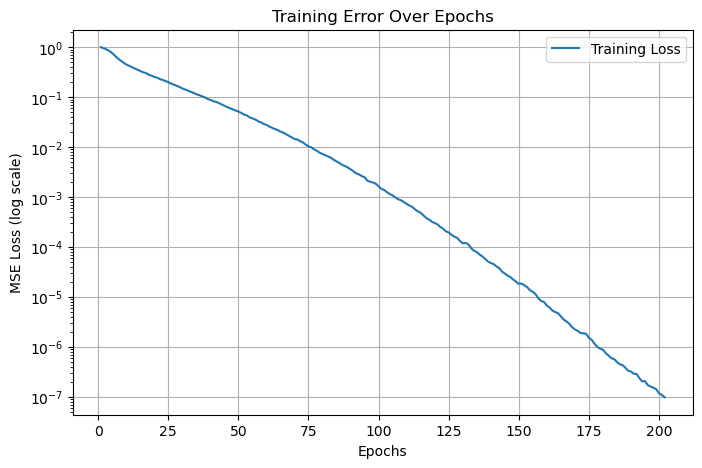

In [11]:
# Plot the loss as function of epochs, using log-scale for the y-axis
import matplotlib.pyplot as plt

# Convert losses to numpy array
losses_ = np.array(losses_)

# Plot training error
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), losses_, label="Training Loss")
plt.yscale("log")  # Log scale for y-axis
plt.xlabel("Epochs")
plt.ylabel("MSE Loss (log scale)")
plt.title("Training Error Over Epochs")
plt.legend()
plt.grid()
plt.show()


=========

# Problem 2

## a) Generate training/testing data

Do not change this part. The code snippet greates synthetic data by feeding random inputs through randomly initialized neural network.

In [2]:
# N samples with D inputs and O outputs
N = 100
D = 10
O = 5

# Random mapping from x to y, as small neural network
class CreationModel(nn.Module):
  def __init__(self, D, O, M):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(D, M),
      nn.Tanh(),
      nn.Linear(M, O)
    )

  def forward(self, x):
    return self.layers(x)

# For getting the same data
torch.manual_seed(78798)

# Training data
x = torch.randn(N, D)
noiselevel = 0.1
modelGenerate = CreationModel(D,O,5)
modelGenerate.eval()
y = modelGenerate(x).clone().detach() + noiselevel*torch.randn(N, O)

# Test data
N_test = 10000
x_test = torch.randn(N_test, D)
y_test = modelGenerate(x_test).clone().detach()  + noiselevel*torch.randn(N_test, O)

## Pre-defined model

Do not change this part. The parameter $M$ controls the size/complexity of the network.

In [3]:
class RegressionModel(nn.Module):
  def __init__(self, D, O, M):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(D, M),
      nn.ReLU(),
      nn.Linear(M, M),
      nn.ReLU(),
      nn.Linear(M, O)
    )

  def forward(self, x):
    return self.layers(x)

## b) Train model and validate the double descent principle

In [9]:
# Use full data for gradients
B = N
data_loader = DataLoader(TensorDataset(x,y), batch_size=B, shuffle=True)

# Loop over some range of M values. With these parameters logspace generates M=2 twice, so dropping the first entry
Mvalues = np.logspace(np.log10(2),np.log10(60),num=15,dtype='int')[1:]
losses = np.zeros((len(Mvalues),2))
for mi, M in enumerate(Mvalues):
    # TODO: Define the model
    model = RegressionModel(D, O, M)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    # TODO: Train it until convergence
    for epoch in range(8000):  
        model.train()
        for X_batch, Y_batch in data_loader:
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()
    
    # TODO: Evaluate both training and test error, and store them
    model.eval()
    with torch.no_grad():
        trainloss = criterion(model(x), y)
        testloss = criterion(model(x_test), y_test)

    losses[mi,0] = trainloss.item()
    losses[mi,1] = testloss.item()

### Plot the final training loss and the final test loss

The code below is provided as an example; you may need to modify it to be compatible with your results. Make some effort to make the plot easy to read.

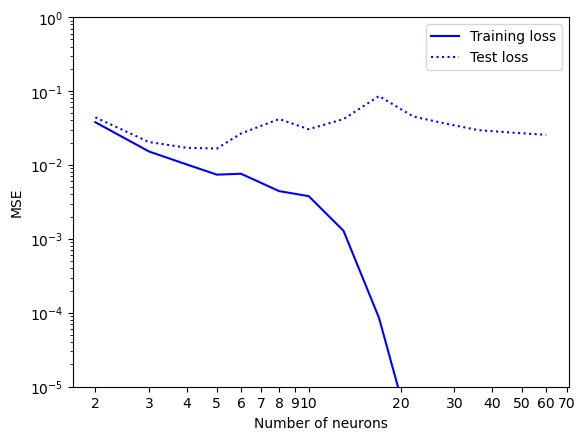

In [10]:
plt.loglog(Mvalues, losses[:,0], 'b-')
plt.loglog(Mvalues, losses[:,1], 'b:')
plt.legend(['Training loss', 'Test loss'])
ax = plt.gca(); ax.set_ylim([10**(-5),10**(0)])
ax.set_ylabel("MSE")
ax.set_xlabel("Number of neurons")
# Customize x-axis to show more detailed labels
from matplotlib.ticker import LogLocator, ScalarFormatter
ax.xaxis.set_major_locator(LogLocator(base=10.0, subs=np.arange(1, 10)))
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.show()

### c) Having more data can hurt

Show that increasing the amount of data helps when around the interpolation threshold, but that for overparameterized model it may hurt.

## 1 Basic definitions

In [13]:
# Generate the larger training set, using the same process as before
N_large = 500
x_large = torch.randn(N_large, D)
y_large = modelGenerate(x_large).clone().detach() + noiselevel*torch.randn(N_large, O)

# TODO: Identify two values of M you need to answer the question
Mvalues = [13,47] 

# TODO: Repeat the training process for those options. Note that you can use the same code as before, 
# since you only changed the data and the set of M
losses_500 = np.zeros((len(Mvalues),2))
for mi, M in enumerate(Mvalues):
    # TODO: Define the model
    model = RegressionModel(D, O, M)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    # TODO: Train it until convergence
    for epoch in range(4000):  
        model.train()
        for X_batch, Y_batch in data_loader:
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()
    
    # TODO: Evaluate both training and test error, and store them
    model.eval()
    with torch.no_grad():
        trainloss = criterion(model(x), y)
        testloss = criterion(model(x_test), y_test)

    losses_500[mi,0] = trainloss.item()
    losses_500[mi,1] = testloss.item()

print("Test losses")
# TODO
print("Results for different M values when N=100:")
print(f"M = 13:  Test Loss = {losses[7, 1]:.6f}")
print(f"M = 47:  Test Loss = {losses[12, 1]:.6f}")

print("Results for different M values when N=500:")
for mi, M in enumerate(Mvalues):
    print(f"M = {M}: Test Loss = {losses_500[mi, 1]:.6f}")


Test losses
Results for different M values when N=100:
M = 13:  Test Loss = 0.041710
M = 47:  Test Loss = 0.027300
Results for different M values when N=500:
M = 13: Test Loss = 0.029233
M = 47: Test Loss = 0.028500


## Reporting

**Edit this cell directly to report the requested information.**

### Interpolation threshold

TODO: The interpolation threshold is around M = 20 ,

TODO: For that M, the model has in total 700 parameters

TODO: Explain the findings. Do you observe the expected pattern? Yes, when training loss goes to zero when M increases until the interpolation threshold point, test loss reaches to its peak. 
If not, what might have been a problem?
The training loss significantly decreases **around M≈20** where the MSE is below 0.0001.After this point, training loss drops to near zero, indicating the model has enough parameters to interpolate (memorize) the training data.
For **M=20, D=10, O=5**, ; 
Total Parameters=DM+MM+MO, input layer : 200+400+100, 
So, **Total Parameters=700** 

### More data can hurt

TODO: Explain your choices of M values, report the test errors for the different amounts of training data, and explain the findings.

Test losses
Results for different M values when N=100:
M = 13:  Test Loss = 0.041710
M = 47:  Test Loss = 0.027300
Results for different M values when N=500:
M = 13: Test Loss = 0.029233
M = 47: Test Loss = 0.028500

I chose an M [13,47] values below the interpolation threshold and another from the overparameterized range to compare their impact on test loss as the data size changes. The results show that for M = 13, increasing N from 100 to 500 significantly reduces the test loss from 0.0417 to 0.0292, indicating that the model benefits from more training data. However, for M = 47, the test loss slightly increases as more data is introduced. At N = 100, the model's high capacity allowed it to memorize patterns effectively, resulting in a lower test loss. But as the dataset grows, test performance may degrade, suggesting that overparameterized models do not always benefit from larger datasets and may struggle with generalization.